# MD Examples

In [1]:
from src.models import *
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import time


In [6]:
import os
os._exit(0)  # Force restart the process


: 

In [5]:
Ns = (101,)  # Number of points in each dimension of 3D grid
# N_vec = np.prod(Ns)  # Total number of grid points
Ls = (20,)  # Length in each dimension
# Define physical parameters
N_electrons = 2 # Number of electrons
beta = 0.5  # Inverse temperature
alpha = 1

N_vec = np.prod(Ns)
# External potential
centers = np.array([-1,4]).reshape(-1,1)
masses = np.array([1.5, 0.5])
print(alpha, beta)
ham = deterministicHamiltonian(Ns, Ls, beta=beta, alpha=alpha, fourier=True, dense=True)
ham.update_external_yukawa(centers, masses)


res_scf = run_scf(ham, N_electrons, max_iter=1000, tol=1e-6)

1 0.5


SCF:   0%|          | 3/1000 [00:00<00:28, 34.81it/s] , error=7.924e-07


Converged at iteration 3 with error 7.924e-07


## SCF 

SCF:   0%|          | 0/1000 [00:00<?, ?it/s] , error=7.924e-07

SCF:   0%|          | 5/1000 [00:00<00:25, 38.79it/s] , error=1.181e-09



Converged at iteration 5 with error 1.181e-09
objective: -4.365591241482164
sum of density: 1.999224403870144
chemical potential: -3.203287473432386
kinetic energy: 2.1329995629015484
external energy: -0.21915751468916672
yukawa energy: 0.10020825585903365
free energy: -10.769681730979727
objective -4.365591241482164


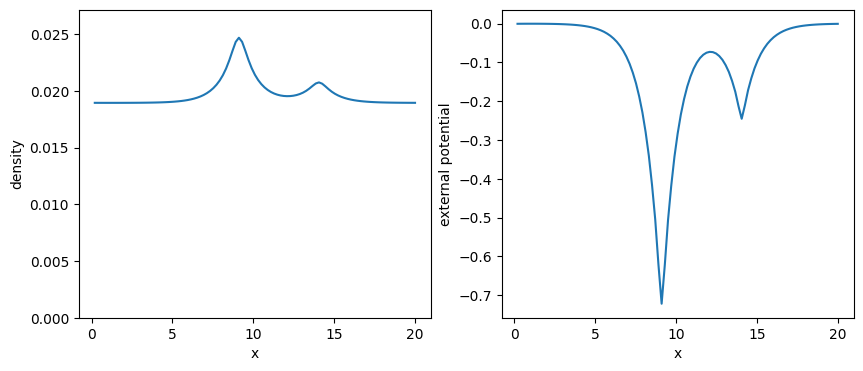

In [4]:

# Define grid size
Ns = (101,)  # Number of points in each dimension of 3D grid
N_vec = np.prod(Ns)  # Total number of grid points
Ls = (20,)  # Length in each dimension

# Define physical parameters
N_electrons = 2 # Number of electrons
beta = 0.5  # Inverse temperature
alpha = 1

# External potential
centers = np.array([-1,4]).reshape(-1,1)
masses = np.array([1.5, 0.5])

# Initialize Hamiltonian
ham = deterministicHamiltonian(Ns, Ls,beta, alpha=alpha)
ham.update_external_yukawa(centers, masses)

# SCF
res_scf = run_scf(ham, N_electrons, max_iter=1000, tol=1e-8)
print('objective:', res_scf["objective"])
print('sum of density:', np.sum(res_scf["density"]))
print('chemical potential:', res_scf["mu"])
print('kinetic energy:', res_scf["energy_kinetic"])
print('external energy:', res_scf["energy_external"])
print('yukawa energy:', res_scf["energy_yukawa"])
print('free energy:', res_scf["energy_free"])
print("objective", res_scf["objective"])


# Plots 
xs = np.linspace(0, Ls[0], Ns[0]+1)[1:]
density_scf = res_scf['density']
density_scf = density_scf.real
plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
plt.plot(xs, density_scf)
plt.ylim([0, np.max(density_scf)*1.1])
plt.xlabel("x")
plt.ylabel("density")

plt.subplot(1,2,2)
plt.plot(xs, ham.potential_external)
plt.xlabel("x")
plt.ylabel("external potential")
plt.show()


In [4]:
print(ham.energy_kinetic(res_scf["density_matrix"]))

0.22491271441289895


## Deterministic MD

Iteration 0, density error 0.9060846626625516 objective 66.01324616309866
Iteration 10, density error 0.1286145473339016 objective 0.5684702298354111
Iteration 20, density error 0.07674151670934398 objective -0.22009667048247464
Iteration 30, density error 0.05792295293899805 objective -0.4058854438010306
Iteration 40, density error 0.046191400474249356 objective -0.4814665617970246
Iteration 50, density error 0.03734612179951465 objective -0.5207913899398332
Iteration 60, density error 0.03034050923025948 objective -0.5440775648768866
Iteration 70, density error 0.024730504448554652 objective -0.5589393092880678
Iteration 80, density error 0.020225838080713942 objective -0.5688884161643897
Iteration 90, density error 0.016601891240960898 objective -0.5757740074711921
Iteration 100, density error 0.013678945171984567 objective -0.5806593464945515
Iteration 110, density error 0.011313575342634944 objective -0.5841939880232511
Iteration 120, density error 0.009392139964517016 objective -

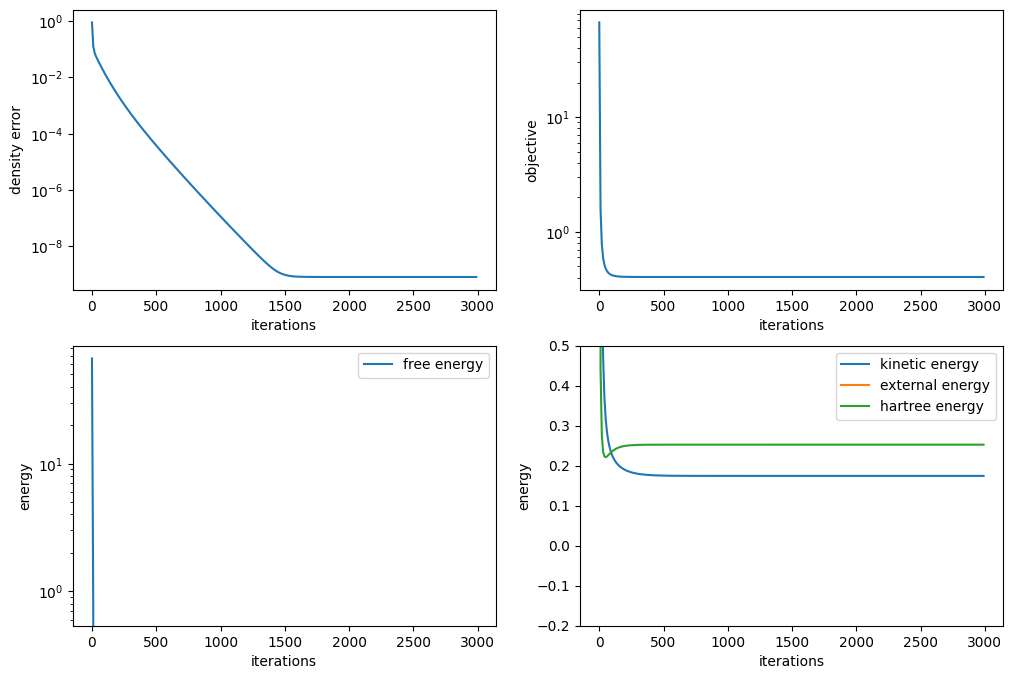

In [3]:

max_iter = 3000
eval_iter = 10


H = np.zeros([N_vec, N_vec])
eye = np.eye(N_vec)
lr = 0.1/beta
iter = 1
iter_eval = 0
iter_eval_list = []
eval_history = defaultdict(list)
mu = res_scf["mu"]
density_scf = res_scf["density"].reshape(N_vec)


for iter in range(max_iter):
    gradient = ham.gradient(H)
    # effective_lr = lr/(lr + beta * np.sqrt(iter))
    effective_lr = lr
    H = (1-effective_lr)*H + effective_lr*(gradient - mu*eye)
    if iter % eval_iter == 0:
        density_DMD = ham.density_function(H)
        density_error = np.linalg.norm(density_DMD.flatten() - density_scf.flatten())
        objective = ham.objective(H=H,mu=mu)
        print(f"Iteration {iter}, density error {density_error}","objective",objective["objective"])
        iter_eval_list.append(iter)
        for key, value in objective.items():
            eval_history[key].append(value)
        eval_history["density_error"].append(density_error)


plt.figure(figsize=(12,8),dpi=100)
plt.subplot(2,2,1)
plt.semilogy(iter_eval_list, eval_history["density_error"])
plt.xlabel("iterations")
plt.ylabel("density error")

plt.subplot(2,2,2)
plt.semilogy(iter_eval_list, np.array(eval_history["objective"])+1)
plt.xlabel("iterations")
plt.ylabel("objective")

plt.subplot(2,2,3)
plt.semilogy(iter_eval_list, eval_history["energy_free"], label="free energy")
plt.xlabel("iterations")
plt.ylabel("energy")
plt.legend()

plt.subplot(2,2,4)
plt.plot(iter_eval_list, eval_history["energy_kinetic"], label="kinetic energy")
plt.plot(iter_eval_list, eval_history["energy_external"], label="external energy")
plt.plot(iter_eval_list, eval_history["energy_yukawa"], label="hartree energy")
# plt.plot(iter_eval_list, eval_history["entropy"], label="entropy")
plt.xlabel("iterations")
plt.ylim([-0.2, 0.5])
plt.ylabel("energy")
plt.legend()


## Stochastic MD

### Cheating version

In [8]:
from collections import defaultdict

density_scf = res_scf["density"]
density_scf = density_scf.real
mu = res_scf["mu"]

max_iter = 500
eval_iter = 1

c_H = -1/2
v_H = jnp.zeros(N_vec)
lr = 0.05/beta
cheat_density_history = np.zeros([max_iter//eval_iter, N_vec])

eval_history = defaultdict(list)
start_time = time.time()

for iter in range(max_iter):
    gradient = ham.gradient_cheat(H,num_samples=10)
    effective_lr = lr
    H = (1-effective_lr)*H + effective_lr*(gradient - mu*eye)

    if iter % eval_iter == 0:
        density_DMD = ham.density_function(H)
        density_error = np.linalg.norm(density_DMD.flatten() - density_scf.flatten())
        objective = ham.objective(H=H,mu=mu)
        for key, value in objective.items():
            eval_history[key].append(value)
        eval_history["density_error"].append(density_error)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Iteration {iter}, density error {density_error}, objective {objective['objective']}, Time {elapsed_time:.4f}s")
        cheat_density_history[iter//eval_iter] = density_DMD.flatten()


Iteration 0, density error 0.0005081437922117875, objective -0.5952704004918696, Time 0.4811s
Iteration 1, density error 0.00013184111867177784, objective -0.5952727226831823, Time 0.5087s
Iteration 2, density error 0.00023152414434999882, objective -0.5952724239549922, Time 0.5358s
Iteration 3, density error 0.00014488933354301568, objective -0.5952726873246221, Time 0.5626s
Iteration 4, density error 0.00023814270745495906, objective -0.5952723569873993, Time 0.5889s
Iteration 5, density error 0.00029922858840770403, objective -0.595272108820197, Time 0.6157s
Iteration 6, density error 0.0003702420688837925, objective -0.5952717215647578, Time 0.6422s
Iteration 7, density error 0.0005458977446140831, objective -0.595270236887932, Time 0.6689s


/home/jovyan/project/envs/jax/lib/python3.10/site-packages/jax/_src/array.py:481: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


Iteration 8, density error 0.00047318494475912567, objective -0.5952708341811564, Time 0.6956s
Iteration 9, density error 0.00048823262796763623, objective -0.5952707401481909, Time 0.7220s
Iteration 10, density error 0.00040635983926200474, objective -0.5952714538371922, Time 0.7470s
Iteration 11, density error 0.00043270302657544784, objective -0.5952712405444951, Time 0.7715s
Iteration 12, density error 0.0006014941760227551, objective -0.595269658278393, Time 0.7959s
Iteration 13, density error 0.0008489981279699901, objective -0.5952669265649534, Time 0.8207s
Iteration 14, density error 0.000804786313702628, objective -0.5952674220801513, Time 0.8451s
Iteration 15, density error 0.0008381105800704023, objective -0.5952667976325527, Time 0.8694s
Iteration 16, density error 0.0010868205221016476, objective -0.595262226552931, Time 0.8937s
Iteration 17, density error 0.0009016701069658655, objective -0.5952657305907617, Time 0.9184s
Iteration 18, density error 0.000826015380969511, o

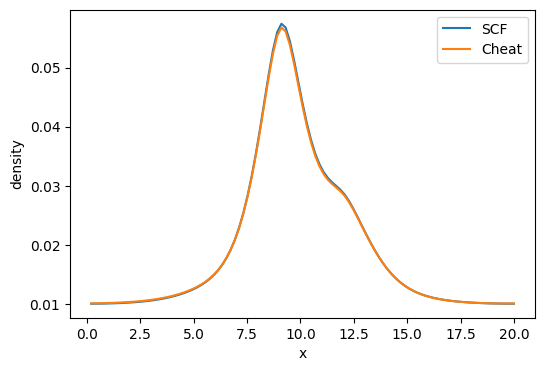

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(xs, density_scf, label="SCF")
plt.plot(xs, cheat_density_history[-1], label="Cheat")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.show()

### Contour version

In [ ]:
from collections import defaultdict

stochastic_ham = StochasticHamiltonian(Ns, Ls, beta,alpha=alpha)
stochastic_ham.update_external_yukawa(centers, masses)

density_scf = res_scf["density"]
density_scf = density_scf.real
mu = res_scf["mu"]

max_iter = 500
eval_iter = 1

c_H = -1/2
v_H = jnp.zeros(N_vec)
lr = 0.05/beta
smd_density_history = np.zeros([max_iter//eval_iter, N_vec])

eval_history = defaultdict(list)
start_time = time.time()

for iter in range(max_iter):
    # print(iter)           
    grad_c_H, grad_v_H = stochastic_ham.gradient(c_H, v_H,N_samples=10,mu=mu)
    effective_lr = lr
    # c_H = (1-effective_lr)*c_H + effective_lr*grad_c_H                                                          
    v_H = (1-effective_lr)*v_H + effective_lr*grad_v_H
    if iter % eval_iter == 0:
        stochastic_ham.update_poles_shifts(c_H, v_H)
        density_DMD = stochastic_ham.density_function(c_H, v_H) 
        density_error = np.linalg.norm(density_DMD.flatten() - density_scf.flatten())
        objective = stochastic_ham.objective(c_H, v_H)
        for key, value in objective.items():
            eval_history[key].append(value)
        eval_history["density_error"].append(density_error)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Iteration {iter}, density error {density_error}, objective {objective['objective']}, Time {elapsed_time:.4f}s")
        smd_density_history[iter//eval_iter] = density_DMD.flatten()


(101,)
1.6764127232973547


Text(0, 0.5, 'density error')

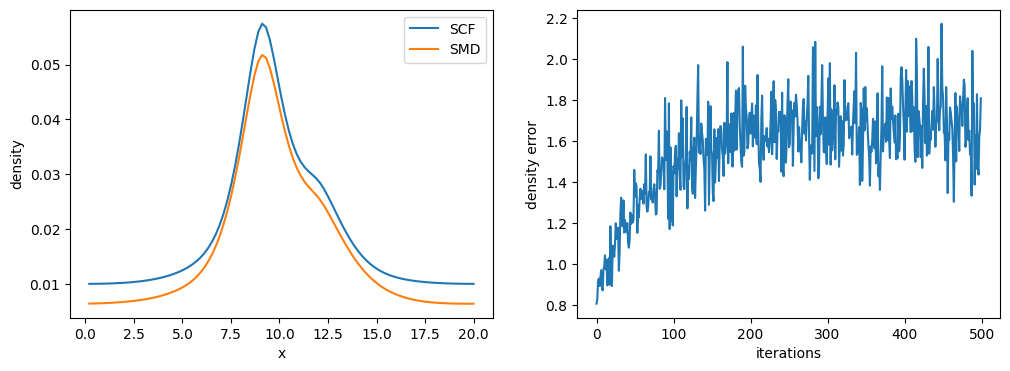

In [12]:

num_eval = smd_density_history.shape[0]
# average_density = np.mean(smd_density_history[-200:,:],0)
average_density = np.mean(smd_density_history[-250:,:],0)
print(average_density.shape)
x_vec = np.linspace(0, Ls[0], Ns[0]+1)[1:]
print(sum(average_density))


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_vec, density_scf, label="SCF")
plt.plot(x_vec, average_density, label="SMD")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()

plt.subplot(1,2,2)
plt.plot(eval_history["sum_rho"])
plt.xlabel("iterations") 
plt.ylabel("density error")

